In [ ]:
!pip install mrcnn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for mrcnn: filename=mrcnn-0.2-py3-none-any.whl size=54929 sha256=8bdd19ddfadf481559b34979231e0a550267b9b86146e20b985f5b8e557504d9
  Stored in directory: /root/.cache/pip/wheels/f6/66/35/4956a489776a1db0ee24e0c33a9088c1b5d68eb5dc2654f0b2
Successfully built mrcnn


In [ ]:
!pip install tensorflow==2.12.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Mask RCNN for SAR Building Detection

# Import Statements

Find root directory and set directory to save logs and model.

In [ ]:
import collections.abc
collections.Iterable = collections.abc.Iterable
collections.Mapping = collections.abc.Mapping
collections.MutableSet = collections.abc.MutableSet
collections.MutableMapping = collections.abc.MutableMapping

import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf
import sys

sys.path.append('/content/drive/MyDrive/439D PROJECT/mrcnn repo/Mask_RCNN/mrcnn')
import model
import utils
import visualize

# Root directory of the project
ROOT_DIR = os.path.abspath("")

from config import Config
from model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Metrics

For classes = precision and recall are defined for 2 class problems, if we add roads we will have to modify

Accuracy - raw percentage of pixel classification accuracy

IoU- mean across classes of class intersection between prediction and label divided by class union between prediction and label - for each class: True positives/(True Positives + False positives + False Negatives)

Precision- True Positives/(True Positives + False Positives) = True positives/toal predicted positives

Recall- True Positives/(True Positives + False Negatives) = true positives/total ground truth positives

F1 Score- Harmonic Mean of Precision and Recall: 2Precision*Recall/(Precision+Recall)

In [ ]:
def accuracy(y_true,y_pred):
  accuracy = K.sum(tf.cast((y_true==y_pred),tf.float(64)))/K.prod(y_true.shape)
  return accuracy

def IoU(y_true,y_pred):
  true_pos = K.sum(K.round(K.clip(y_true*y_pred,0,1)))
  total_pos = K.sum(K.round(K.clip(y_pred)))
  ground_pos = K.sum(K.round(K.clip(y_pred,0,1)))
  false_pos = total_pos - true_pos
  false_neg = ground_pos - true_pos
  IoU = (true_pos)/(true_pos + false_pos + false_neg + K.epsilon())
  return IoU

def precision(t_true,y_pred):
  true_pos = K.sum(K.round(K.clip(y_true*y_pred,0,1)))
  total_pos = K.sum(K.round(K.clip(y_pred,0,1)))
  precision = true_pos/(total_pos + K.epsilon())
  return precision

def recall(y_true,y_pred):
  true_pos = K.sum(K.round(K.clip(y_true*y_pred,0,1)))
  ground_pos = K.sum(K.round(K.clip(y_pred,0,1)))
  recall = true_pos/(ground_pos + K.epsilon())
  return recall

def F1_score(y_true,y_pred):
  precision = precision(y_true,y_pred)
  recall = recall(y_true,y_pred)
  F1_score = (2*precision*recall)/(precision+recall + K.epsilon())
  return F1_score

Shapes Config

In [ ]:
class ShapesConfig(Config):
    # Give the configuration a recognizable name
    NAME = "buildings"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 1 shape (buildings)

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = ShapesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [ ]:
# Create the Model
model = model.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)

# Load the last model you trained and continue training
model.load_weights(filepath='/content/drive/MyDrive/439D PROJECT/mrcnn repo/mask_rcnn_coco.h5', 
                   by_name=True, 
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])

In [ ]:
print(model.keras_model.summary())

In [ ]:
from sklearn.model_selection import train_test_split

images = np.load('/content/drive/MyDrive/439D PROJECT/processed data/imgs_1.npy')
labels = np.load('/content/drive/MyDrive/439D PROJECT/processed data/labels_1.npy')

images = (images/255).astype(np.float32)
labels = labels.astype(np.float32)

img_train,img_test,label_train,label_test = train_test_split(images,labels)

In [ ]:
print(len(label_train))

3749


In [ ]:
from numpy import zeros, asarray
import cv2

def clean_name(name):
            """Returns a shorter version of object names for cleaner display."""
            return ",".join(name.split(",")[:1])


class BuildingDataset(utils.Dataset):

    def __init__(self, images, labels, class_map=None):
        self._image_ids = []
        self.image_info = []
        self.source_class_ids = []
        self.images = images
        self.labels = labels
        self.num_classes = 2
        self.class_info = [{"source": "0", "id": 0, "name": "BG"}, {"source": "1", "id": 1, "name":"building"}]
        self.class_names = [clean_name(c["name"]) for c in self.class_info]
        for i in range(0, len(images)-1):
          self._image_ids.append(i)
          self.source_class_ids.append(1)
          img_info_temp = {
            "id": i,
            "source": i
          }
          self.image_info.append(img_info_temp)
        # Background is always the first class


    def load_image(self, image_id):
      backtorgb = cv2.cvtColor(images[image_id], cv2.COLOR_GRAY2RGB)
      backtorgb = backtorgb*255
      return backtorgb

    def load_mask(self, image_id):
      class_ids = []
      class_ids.append(self.class_names.index('building'))
      class_ids.append(self.class_names.index('building'))
      class_ids.append(self.class_names.index('building'))
      backtorgb = cv2.cvtColor(labels[image_id], cv2.COLOR_GRAY2RGB)
      backtorgb = backtorgb*255
      return backtorgb, asarray(class_ids, dtype='int32')

  

In [ ]:
train_dataset = BuildingDataset(img_train, label_train)
validation_dataset = BuildingDataset(img_test, label_test)


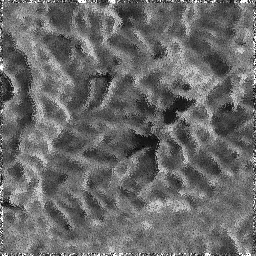

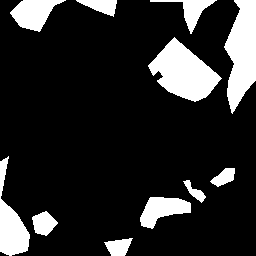

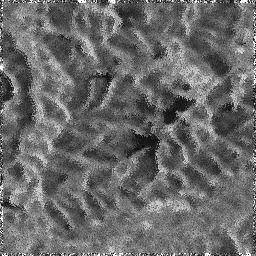

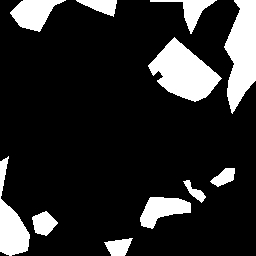

256


In [ ]:
from google.colab.patches import cv2_imshow as show
show(train_dataset.load_image(1400))
show(train_dataset.load_mask(1400)[0])



show(images[1400]*255)
show(labels[1400]*255)
print(len(train_dataset.labels[293]))

In [ ]:
model.train(train_dataset=train_dataset, 
            val_dataset=validation_dataset, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/logs/buildings20230505T1604/mask_rcnn_buildings_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistributed)
mrcnn_mask_deconv      (Time

ERROR:root:Error processing image {'id': 1208, 'source': 1208}
Traceback (most recent call last):
  File "/content/drive/MyDrive/439D PROJECT/mrcnn repo/Mask_RCNN/mrcnn/model.py", line 1750, in data_generator
    load_image_gt(dataset, config, image_id, augment=augment,
  File "/content/drive/MyDrive/439D PROJECT/mrcnn repo/Mask_RCNN/mrcnn/model.py", line 1323, in load_image_gt
    mask = utils.minimize_mask(bbox, mask, config.MINI_MASK_SHAPE)
  File "/content/drive/MyDrive/439D PROJECT/mrcnn repo/Mask_RCNN/mrcnn/utils.py", line 532, in minimize_mask
    m = resize(m, mini_shape)
  File "/content/drive/MyDrive/439D PROJECT/mrcnn repo/Mask_RCNN/mrcnn/utils.py", line 899, in resize
    return skimage.transform.resize(
  File "/usr/local/lib/python3.10/dist-packages/skimage/transform/_warps.py", line 160, in resize
    order = _validate_interpolation_order(input_type, order)
  File "/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py", line 724, in _validate_interpolation_ord

ValueError: ignored

# Start training the model

Start by training the heads of the train dataset with the heads of the val dataset.

Then, after the model is trained once, we will train it again with all layers.

dataset_train = np.array of np.arrays holding pixel values of each image

dataset_val = np.array of np.arrays holding CORRECT pixels values each mask for matching image

TO:DO 

In [ ]:
model.summary()